<a href="https://colab.research.google.com/github/vanderbilt-data-science/lo-achievement/blob/main/speech_to_text_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project IO Achievement - Speech-to-text Model Comparizon

## Problem Definition

We'll start by developing this in Colab, and we want a simple speech transcription. It is known that there are some speed issues in terms of transcription, so this Colab should implement and compare pros/cons of:

- OpenAI Whisper API       
- Huggingface API (by downloading model)             
- Huggingface API (by using API endpoint, so you never download the model, you just use the inference API + Huggingface Hub).

Which seems to do the best, and are there differences? What are the caveats of using one approach vs the other?


## Libraries

This section will install and import some important libraries such as Langchain, openai, Gradio, and so on

In [1]:
# install libraries here
# -q flag for "quiet" install
%%capture
!pip install -q langchain
!pip install -q openai
!pip install -q gradio
!pip install -q transformers
!pip install -q datasets
!pip install -q huggingsound
!pip install -q torchaudio
!pip install -q git+https://github.com/openai/whisper.git

In [44]:
# import libraries here
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain import ConversationChain, LLMChain, PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferWindowMemory
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
import openai
import os
from getpass import getpass
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode
import ipywidgets as widgets
from IPython.display import clear_output
import time
import requests
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
# from torchaudio.transforms import Resample
import whisper
from huggingsound import SpeechRecognitionModel
import numpy as np
import torch
import librosa
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from jiwer import wer
import pandas as pd
from IPython.display import display, HTML

## API Keys

Use these cells to load the API keys required for this notebook. The below code cell uses the `getpass` library.

In [3]:
openai_api_key = getpass()
os.environ["OPENAI_API_KEY"] = openai_api_key
openai.api_key = openai_api_key

··········


## Data Loading

In [4]:
def download(audio_url, save_path):
    r = requests.get(audio_url, stream = True)

    with open(save_path, "wb") as file:
        for block in r.iter_content(chunk_size = 1024):
            if block:
                file.write(block)

In [5]:
audio_url1 = 'https://drive.google.com/uc?export=download&id=1fIPAktKZEScqcNqv4GTXvB7eukh41Arf'
# audio_url2 = 'https://drive.google.com/uc?export=download&id=1uPk3EbQokbY7NpoolE3vSoitHeySctpJ'
audio_url2 = 'https://drive.google.com/uc?export=download&id=1X0IcDLyQvyGBH8JBxRXpIIk1iaUae1ZE'
# audio_url3 = 'https://drive.google.com/uc?export=download&id=1gzluFXFPZ7t8tq32MTTKOozHNyb7s8Ll'
audio_url3 = 'https://drive.google.com/uc?export=download&id=1xn1q1uLr6HhDLmG7kX6ZllbX2AUFyAI4'

# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
# sample = ds[0]["audio"]

In [6]:
download(audio_url1, 'audio1.mp3')
download(audio_url2, 'audio2.mp3')
download(audio_url3, 'audio3.mp3')

## Models

OpenAI Whisper API: https://platform.openai.com/docs/guides/speech-to-text

Hugging Face API: https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=trending
- openai/whisper-large-v2
- pyannote/speaker-diarization ?
- jonatasgrosman/wav2vec2-large-xlsr-53-english
- openai/whisper-large
- openai/whisper-base
- openai/whisper-small
- openai/whisper-medium
- guillaumekln/faster-whisper-large-v2
- facebook/mms-1b-all

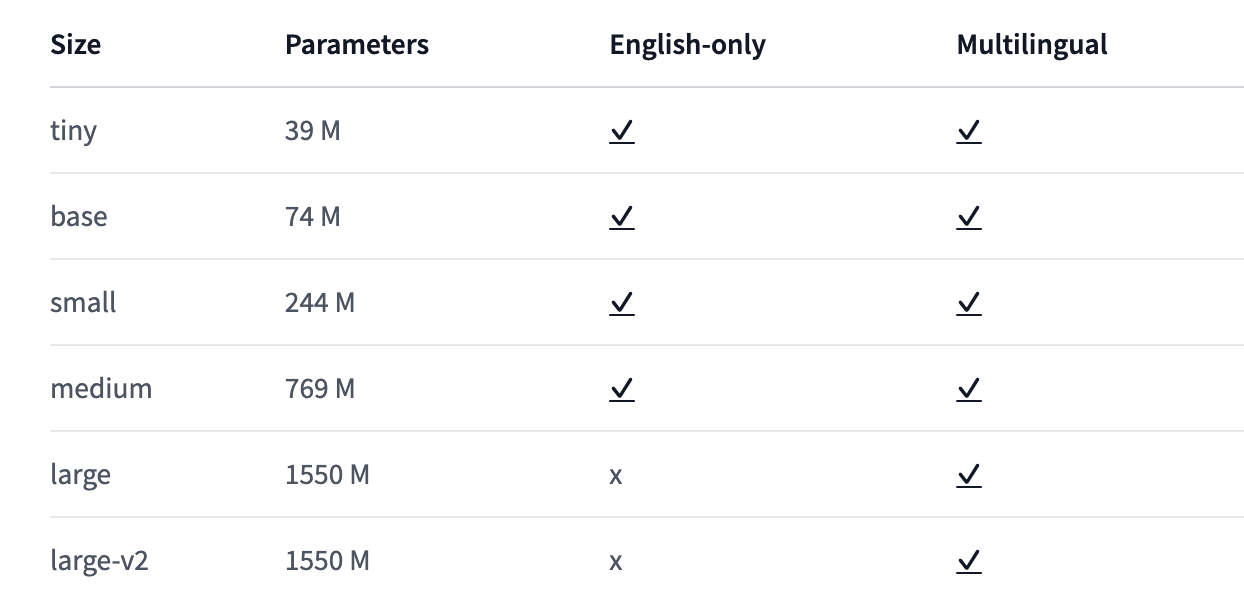

### OpenAI Whisper API

https://platform.openai.com/docs/guides/speech-to-text

In [12]:
total_time = 0
runs = 10

for i in range(runs):
    file = open('audio1.mp3', "rb")

    start = time.time()
    transcription1 = openai.Audio.transcribe("whisper-1", file)
    end = time.time()

    total_time += (end - start)

average_time1 = total_time / runs
print("Average OpenAI Whisper API transcription time: ", average_time1)

for i in range(runs):
    file = open('audio2.mp3', "rb")

    start = time.time()
    transcription2 = openai.Audio.transcribe("whisper-1", file)
    end = time.time()

    total_time += (end - start)

average_time2 = total_time / runs
print("Average OpenAI Whisper API transcription time: ", average_time2)

for i in range(runs):
    file = open('audio3.mp3', "rb")

    start = time.time()
    transcription3 = openai.Audio.transcribe("whisper-1", file)
    end = time.time()

    total_time += (end - start)

average_time3 = total_time / runs
print("Average OpenAI Whisper API transcription time: ", average_time3)


Average OpenAI Whisper API transcription time:  2.087932562828064
Average OpenAI Whisper API transcription time:  3.9225234985351562
Average OpenAI Whisper API transcription time:  5.70369656085968


In [13]:
transcription1['text']

"Sawyer and Susie stared at the big door in front of them. For twins, they didn't look anything alike. Sawyer was blonde and short. Susie was tall with dark hair and freckles. But those were just the smallest differences between them. In fact, they were pretty sure they were born on different planets, on opposite ends of the universe. Even so, they were stuck together as usual, and now they stood on their grandpa's front porch, deciding their next move."

In [14]:
transcription2['text']

'Once upon a time, there was a giraffe named Ginger. Ginger lived in Kenya, a country in Africa. Like all giraffes, Ginger had a long neck and long legs. Because she was so tall, she was able to eat food from the very tops of the trees in the savannah. The savannah in Africa is an area with lots of grass and some trees.'

In [15]:
transcription3['text']

"Well, how do you go about making a small rowboat? We just make the small scale model and draft it from that. Make a keel out. You make a scale model first? Most everybody does. Make a scale model or else they draft them out. Draw them out on paper. Either one you want to, it doesn't matter. How big are these scale models?"

### openai/whisper-large-v2

https://huggingface.co/openai/whisper-large-v2

https://github.com/openai/whisper

In [16]:
def transcribe_audio(save_path, model_name, num_iterations):

    model = whisper.load_model(model_name)
    total_times = []

    for i in range(num_iterations):  # number of iterations
        start = time.time()

        # load audio and pad/trim it to fit 30 seconds
        audio = whisper.load_audio(save_path)
        audio = whisper.pad_or_trim(audio)

        # make log-Mel spectrogram and move to the same device as the model
        mel = whisper.log_mel_spectrogram(audio).to(model.device)

        # detect the spoken language
        _, probs = model.detect_language(mel)

        # decode the audio
        options = whisper.DecodingOptions()
        result = whisper.decode(model, mel, options)

        end = time.time()
        total_times.append(end - start)

    # Calculate the average
    average_time = np.mean(total_times)
    print("Average", model_name, "transcription time: ", average_time)

    # print the recognized text
    print(result.text)

    return average_time, result.text


In [21]:
whisper_large_v2_1 = transcribe_audio('audio1.mp3', "large-v2", 10)
whisper_large_v2_2 = transcribe_audio('audio2.mp3', "large-v2", 10)
whisper_large_v2_3 = transcribe_audio('audio3.mp3', "large-v2", 10)

Average large-v2 transcription time:  7.058776140213013
Sawyer and Susie stared at the big door in front of them. For twins, they didn't look anything alike. Sawyer was blonde and short, Susie was tall with dark hair and freckles. But those were just the smallest differences between them. In fact, they were pretty sure they were born on different planets, on opposite ends of the universe. Even so, they were stuck together as usual, and now they stood on their grandpa's front porch, deciding their next move.
Average large-v2 transcription time:  5.123278546333313
Once upon a time, there was a giraffe named Ginger. Ginger lived in Kenya, a country in Africa. Like all giraffes, Ginger had a long neck and long legs. Because she was so tall, she was able to eat food from the very tops of the trees in the savannah. The savannah in Africa is an area with lots of grass and some trees.
Average large-v2 transcription time:  5.159456348419189
How do you go about making a small rowboat? We just ma

### whisper-large

In [22]:
whisper_large_1 = transcribe_audio('audio1.mp3', "large", 10)
whisper_large_2 = transcribe_audio('audio2.mp3', "large", 10)
whisper_large_3 = transcribe_audio('audio3.mp3', "large", 10)

Average large transcription time:  7.4871098279953
Sawyer and Susie stared at the big door in front of them. For twins, they didn't look anything alike. Sawyer was blonde and short, Susie was tall with dark hair and freckles. But those were just the smallest differences between them. In fact, they were pretty sure they were born on different planets, on opposite ends of the universe. Even so, they were stuck together as usual, and now they stood on their grandpa's front porch, deciding their next move.
Average large transcription time:  5.103005862236023
Once upon a time, there was a giraffe named Ginger. Ginger lived in Kenya, a country in Africa. Like all giraffes, Ginger had a long neck and long legs. Because she was so tall, she was able to eat food from the very tops of the trees in the savannah. The savannah in Africa is an area with lots of grass and some trees.
Average large transcription time:  5.136638736724853
How do you go about making a small rowboat? We just make the smal

### whisper-medium

In [23]:
whisper_medium_1 = transcribe_audio('audio1.mp3', "medium", 10)
whisper_medium_2 = transcribe_audio('audio2.mp3', "medium", 10)
whisper_medium_3 = transcribe_audio('audio3.mp3', "medium", 10)

100%|██████████████████████████████████████| 1.42G/1.42G [00:10<00:00, 141MiB/s]


Average medium transcription time:  4.867928552627563
Sawyer and Susie stared at the big door in front of them. For twins, they didn't look anything alike. Sawyer was blonde and short, Susie was tall with dark hair and freckles. But those were just the smallest differences between them. In fact, they were pretty sure they were born on different planets, on opposite ends of the universe. Even so, they were stuck together as usual, and now they stood on their grandpa's front porch, deciding their next move.
Average medium transcription time:  3.6824806213378904
Once upon a time, there was a giraffe named Ginger. Ginger lived in Kenya, a country in Africa. Like all giraffes, Ginger had a long neck and long legs. Because she was so tall, she was able to eat food from the very tops of the trees in the savanna. The savanna in Africa is an area with lots of grass and some trees.
Average medium transcription time:  4.072535729408264
How do you go about making a small rowboat? We just make the 

### whisper-small

In [24]:
whisper_small_1 = transcribe_audio('audio1.mp3', "small", 10)
whisper_small_2 = transcribe_audio('audio2.mp3', "small", 10)
whisper_small_3 = transcribe_audio('audio3.mp3', "small", 10)

100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 118MiB/s]


Average small transcription time:  2.7674500703811646
Sawyer and Susie stared at the big door in front of them. For twins, they didn't look anything alike. Sawyer was blonde and short, Susie was tall with dark hair and freckles, but those were just the smallest differences between them. In fact, they were pretty sure they were born on different planets, on opposite ends of the universe. Even so, they were stuck together as usual, and now they stood on their grandpa's front porch, deciding their next move.
Average small transcription time:  1.9433160781860352
Once upon a time, there was a giraffe named Ginger. Ginger lived in Kenya, a country in Africa. Like all giraffes, Ginger had a long neck and long legs. Because she was so tall, she was able to eat food from the very tops of the trees in the savannah. The savannah in Africa is an area with lots of grass and sun trees.
Average small transcription time:  2.037943434715271
How do you go about making a small robot? We just make the sma

### jonatasgrosman/wav2vec2-large-xlsr-53-english

In [25]:
LANG_ID = "en"
MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
SAMPLES = 10

In [26]:
# Load pre-trained model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")
model = Wav2Vec2ForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")


In [28]:
# Load your audio file
speech_array, sampling_rate = librosa.load("audio1.mp3", sr=16_000)

inputs = processor(speech_array, sampling_rate=16_000, return_tensors="pt", padding=True)

# We'll time the model inference for 10 iterations and take the average
times = []
for _ in range(10):
    start_time = time.time()
    with torch.no_grad():
        logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits
    end_time = time.time()
    times.append(end_time - start_time)

# Compute the average over 10 runs and print it
average_time4 = np.mean(times)
print("Average inference time over 10 iterations: {:.4f} seconds".format(average_time4))

# Decode the logits to texts
predicted_ids = torch.argmax(logits, dim=-1)
transcription4 = processor.decode(predicted_ids[0])

print("Transcription:", transcription4)

#########################################

# Load your audio file
speech_array, sampling_rate = librosa.load("audio2.mp3", sr=16_000)

inputs = processor(speech_array, sampling_rate=16_000, return_tensors="pt", padding=True)

# We'll time the model inference for 10 iterations and take the average
times = []
for _ in range(10):
    start_time = time.time()
    with torch.no_grad():
        logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits
    end_time = time.time()
    times.append(end_time - start_time)

# Compute the average over 10 runs and print it
average_time5 = np.mean(times)
print("Average inference time over 10 iterations: {:.4f} seconds".format(average_time5))

# Decode the logits to texts
predicted_ids = torch.argmax(logits, dim=-1)
transcription5 = processor.decode(predicted_ids[0])

print("Transcription:", transcription5)

#########################################

# Load your audio file
speech_array, sampling_rate = librosa.load("audio3.mp3", sr=16_000)

inputs = processor(speech_array, sampling_rate=16_000, return_tensors="pt", padding=True)

# We'll time the model inference for 10 iterations and take the average
times = []
for _ in range(10):
    start_time = time.time()
    with torch.no_grad():
        logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits
    end_time = time.time()
    times.append(end_time - start_time)

# Compute the average over 10 runs and print it
average_time6 = np.mean(times)
print("Average inference time over 10 iterations: {:.4f} seconds".format(average_time6))

# Decode the logits to texts
predicted_ids = torch.argmax(logits, dim=-1)
transcription6 = processor.decode(predicted_ids[0])

print("Transcription:", transcription6)


Average inference time over 10 iterations: 10.4349 seconds
Transcription: sawyer and suzi stared at the big door in front of themfor twins they didn't look anything a-likesawyer was blond and short susie was tall with darkhair and freckles but those were just the smallest differences between themin fact they were pretty sure they were born on different planets on opposite ends of the universe even so they were stuck together as usual and now they stood on their grampa's front porch desiding their next move
Average inference time over 10 iterations: 9.4642 seconds
Transcription: once upon a tyme there was a giraffe named ginger ginger lived in canya a country in africalike all jeraffs ginger had long neck and long legs because she was so tall she was able to eat food from the very tops of the trees in the savannathe savanna in africa is an area with lots of grass and some trees
Average inference time over 10 iterations: 9.2326 seconds
Transcription: u how dould you go about making a sma

## Evaluation

### Size

In [32]:
size = pd.DataFrame(columns=['Model', 'Size'])
size.loc[0] = ['OpenAI Whisper API', 'API']
size.loc[1] = ['OpenAI Large-V2', '2.67GB']
size.loc[2] = ['OpenAI Large', '2.67GB']
size.loc[3] = ['OpenAI Medium', '1.42GB']
size.loc[4] = ['OpenAI Small', '461MB']
size.loc[5] = ['wav2vec2-large-xlsr-53-english', '1.26GB']

In [36]:
size.index = size.index + 1
display(HTML(size.to_html(index=True)))

,Model,Size
1,OpenAI Whisper API,API
2,OpenAI Large-V2,2.67GB
3,OpenAI Large,2.67GB
4,OpenAI Medium,1.42GB
5,OpenAI Small,461MB
6,wav2vec2-large-xlsr-53-english,1.26GB


### Speed

In [37]:
speed = pd.DataFrame(columns=['Model', 'Audio1(storybook 27s)', 'Audio2(recording myself 27s)', 'Audio3(interview 27s)'])
speed.loc[0] = ['OpenAI Whisper API', average_time1,average_time2,average_time3]
speed.loc[1] = ['OpenAI Large-V2', whisper_large_v2_1[0],whisper_large_v2_2[0],whisper_large_v2_3[0]]
speed.loc[2] = ['OpenAI Large', whisper_large_1[0],whisper_large_2[0],whisper_large_3[0]]
speed.loc[3] = ['OpenAI Medium', whisper_medium_1[0],whisper_medium_2[0],whisper_medium_3[0]]
speed.loc[4] = ['OpenAI Small', whisper_small_1[0],whisper_small_2[0],whisper_small_3[0]]
speed.loc[5] = ['wav2vec2-large-xlsr-53-english', average_time4,average_time5,average_time6]

In [52]:
speed.index = speed.index + 1
display(HTML(speed.to_html(index=True)))

,Model,Audio1(storybook 27s),Audio2(recording myself 27s),Audio3(interview 27s)
1,OpenAI Whisper API,2.087933,3.922523,5.703697
2,OpenAI Large-V2,7.058776,5.123279,5.159456
3,OpenAI Large,7.487110,5.103006,5.136639
4,OpenAI Medium,4.867929,3.682481,4.072536
5,OpenAI Small,2.767450,1.943316,2.037943
6,wav2vec2-large-xlsr-53-english,10.434880,9.464190,9.232625


### Accuracy (WER: Word Error Rate)
https://pypi.org/project/jiwer/

In [59]:
true_audio1 = '''
Sawyer and Susie stared at the big door in front of them. For twins, they didn't look anything alike. Sawyer was blonde and short. Susie was tall with dark hair and freckles. But those were just the smallest differences between them. In fact, they were pretty sure they were born on different planets, on opposite ends of the universe. Even so, they were stuck together as usual, and now they stood on their grandpa's front porch, deciding their next move.
'''

true_audio2 = '''
Once upon a time, there was a giraffe named Ginger. Ginger lived in Kenya, a country in Africa. Like all giraffes, Ginger had a long neck and long legs. Because she was so tall, she was able to eat food from the very tops of the trees in the savannah. The savannah in Africa is an area with lots of grass and some trees. Sometimes a savannah is called grasslands. The other animals like zebras and antelopes could not reach where Ginger could reach. But Ginger always found food. She loved the leaves and the new buds of the trees
'''

true_audio3 = '''
How do you go about making a, uh, small rowboat? Well, you just make, the uh, small scale model and draft it from that. Make a keel out. You make a scale model first? Mos’, most everybody does, make a scale model or else they draft ’em out, draw them out on paper. Either one you want do-doesn’t matter. How big are these, uh, scale models? A general rule on small type boat, just a three quarter inch to a foot. The large ones are up to a quarter inch to a foot. Uh-huh. An’ what’s the purpose of the, uh, scale, scale model? Well, to determine the length, and the breadth, and the width and all this. Oh, I see. They just use smaller… That’s right. Everything, and then they just scale them up and down. Uh-huh. And, uh, then how do you go about starting to build the, the boat itself? Well, you make a keel first, from the model, or from the draftings, drawings, whatever it is. Then, you make a stem, and a stern. After the small stuff, the small boats, well, you bend the frame, uh, the, you make a molds-what we call the molds, that is, sectionals, sections of it, of the, if they are so far apart, on the boat, you take the shape of it, make sections. What do they use to do that? Plywood? Just plywood or cedar-either, it doesn’t matter.
'''

Well, how do you go about making a small rowboat? We just make the small scale model and draft it from that. Make a keel out. You make a scale model first? Most everybody does. Make a scale model or else they draft them out. Draw them out on paper. Either one you want to, it doesn't matter. How big are these scale models?

In [60]:
WER = pd.DataFrame(columns=['Model', 'Audio1(storybook 27s)', 'Audio2(recording myself 27s)', 'Audio3(interview 27s)'])
WER.loc[0] = ['OpenAI Whisper API', wer(true_audio1, transcription1['text']),wer(true_audio2, transcription2['text']),wer(true_audio3, transcription3['text'])]
WER.loc[1] = ['OpenAI Large-V2', wer(true_audio1, whisper_large_v2_1[1]),wer(true_audio2, whisper_large_v2_2[1]),wer(true_audio3,whisper_large_v2_3[1])]
WER.loc[2] = ['OpenAI Large', wer(true_audio1, whisper_large_1[1]), wer(true_audio2,whisper_large_2[1]),wer(true_audio3,whisper_large_3[1])]
WER.loc[3] = ['OpenAI Medium', wer(true_audio1,whisper_medium_1[1]),wer(true_audio2,whisper_medium_2[1]),wer(true_audio3,whisper_medium_3[1])]
WER.loc[4] = ['OpenAI Small', wer(true_audio1,whisper_small_1[1]),wer(true_audio2,whisper_small_2[1]),wer(true_audio3,whisper_small_3[1])]
WER.loc[5] = ['wav2vec2-large-xlsr-53-english', wer(true_audio1, transcription4),wer(true_audio2, transcription5),wer(true_audio3, transcription6)]

In [62]:
WER.index = WER.index + 1
display(HTML(WER.to_html(index=True)))

,Model,Audio1(storybook 27s),Audio2(recording myself 27s),Audio3(interview 27s)
1,OpenAI Whisper API,0.0000,0.36,0.808333
2,OpenAI Large-V2,0.0125,0.36,0.808333
3,OpenAI Large,0.0125,0.36,0.808333
4,OpenAI Medium,0.0125,0.38,0.829167
5,OpenAI Small,0.0375,0.37,0.829167
6,wav2vec2-large-xlsr-53-english,0.3250,0.53,0.933333


## Conclusion

Considering size, speed and accuracy, OpenAI Whisper API and OpenAI Small on hugging face seem to be the best models to use. OpenAI Small on hugging face is small, quick, and relatively accurate, and OpenAI Whisper API is hosted on cloud, accurate, and also quick.